In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
from lime.lime_tabular import LimeTabularExplainer
import seaborn as sns

In [2]:
#  Load the dataset
data = pd.read_csv('day.csv')

#  Explore the data
print("Data Shape:", data.shape)
print("Data Info:\n", data.info())
print("Missing Values:\n", data.isnull().sum())
print("Unique values in 'season':", data['season'].unique())

#  Encode the target variable ('season')
label_encoder = LabelEncoder()
data['season'] = label_encoder.fit_transform(data['season'])  # Encodes 1-4 to 0-3

#  Select relevant features
features = ['temp', 'hum', 'windspeed', 'holiday', 'weathersit', 'yr', 'weekday', 'cnt']
X = data[features]
y = data['season']

#  Normalize/Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Data Shape: (731, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB
Data Info:
 None
Missing Values:
 instant       0
dteday        0
seaso

In [3]:
#  Softmax function

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability fix
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

In [4]:
#  Cross-Entropy Loss
def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = -np.log(y_pred[range(n_samples), y_true])
    return np.sum(logp) / n_samples

#  One-Hot Encoding for labels
def one_hot_encode(y, num_classes):
    one_hot = np.zeros((y.size, num_classes))
    one_hot[np.arange(y.size), y] = 1
    return one_hot

In [5]:
# Training the Multiclass Logistic Regression model
def LogisticRegressionScratch(X, y, num_classes, lr=0.01, epochs=1000):
    n_samples, n_features = X.shape
    W = np.zeros((n_features, num_classes))
    b = np.zeros((1, num_classes))

    y_one_hot = one_hot_encode(y, num_classes)
    losses = []

    for i in range(epochs):
        # Forward pass
        logits = np.dot(X, W) + b
        y_pred = softmax(logits)
        
        # Loss calculation
        loss = cross_entropy_loss(y, y_pred)
        losses.append(loss)
        
        # Backward pass
        dw = (1 / n_samples) * np.dot(X.T, (y_pred - y_one_hot))
        db = (1 / n_samples) * np.sum(y_pred - y_one_hot, axis=0, keepdims=True)
        
        # Update weights
        W -= lr * dw
        b -= lr * db
        
        # Print loss every 100 epochs
        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {loss:.4f}")
    
    return W, b, losses

In [6]:
#  Prediction
def predict(X, W, b):
    logits = np.dot(X, W) + b
    y_prob = softmax(logits)  # Probabilities for each class
    y_pred = np.argmax(y_prob, axis=1)  # Predicted classes
    return y_pred, y_prob  # Returns both predicted classes and probabilities


# 📊 Explanation of Logistic Regression Scratch Implementation

This section explains the step-by-step implementation of Logistic Regression from scratch.

1. **Softmax Function:**
   - Converts logits (raw scores) into probabilities.
   - Formula: 
     $$
     \text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}
     $$
   - Stability fix: Subtracting the max value in logits to prevent overflow.

2. **Cross-Entropy Loss:**
   - Measures how far the predicted probabilities are from the true labels.
   - Formula: 
     $$
     L = -\frac{1}{N} \sum_{i=1}^N \log(p_{y_i})
     $$
   - Where \( p_{y_i} \) is the predicted probability of the correct class.

3. **One-Hot Encoding:**
   - Converts class labels into one-hot vectors for multiclass classification.
   - Example: For class 2 in 4 classes → [0, 0, 1, 0].

4. **Training Process (Gradient Descent):**
   - Initializes weights and biases to zero.
   - Performs forward pass: logits → softmax → loss.
   - Performs backward pass: Computes gradients and updates weights.
   - Updates continue for a fixed number of epochs.
   - Gradient formulas:
     $$
     \frac{\partial L}{\partial W} = \frac{1}{N} X^T (\hat{Y} - Y) \\
     \frac{\partial L}{\partial b} = \frac{1}{N} \sum (\hat{Y} - Y)
     $$

5. **Prediction:**
   - Uses the trained weights and biases to make predictions.
   - Applies softmax to obtain probabilities and selects the class with the highest probability.

In [7]:
#  Model Training
num_classes = len(np.unique(y_train))
W, b, losses = LogisticRegressionScratch(X_train, y_train.values, num_classes, lr=0.01, epochs=1000)


#  Model Evaluation

y_pred_train, y_prob_train = predict(X_train, W, b)
y_pred_test, y_prob_test = predict(X_test, W, b)

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

Epoch 0, Loss: 1.3863
Epoch 100, Loss: 1.1829
Epoch 200, Loss: 1.0830
Epoch 300, Loss: 1.0243
Epoch 400, Loss: 0.9846
Epoch 500, Loss: 0.9551
Epoch 600, Loss: 0.9319
Epoch 700, Loss: 0.9129
Epoch 800, Loss: 0.8970
Epoch 900, Loss: 0.8834
Training Accuracy: 0.6523972602739726
Testing Accuracy: 0.6462585034013606


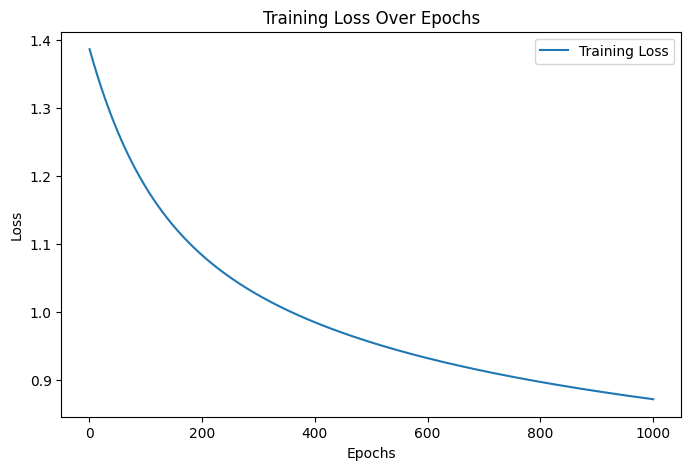

In [8]:
# Plot training loss over epochs

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [9]:
# Accuracy from Scratch
def accuracy_score_scratch(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    return correct_predictions / len(y_true)


In [10]:
# Compute and print accuracy
train_accuracy = accuracy_score_scratch(y_train.values, y_pred_train)
test_accuracy = accuracy_score_scratch(y_test.values, y_pred_test)

print(f"\nTraining Accuracy (Scratch): {train_accuracy:.4f}")
print(f"Testing Accuracy (Scratch): {test_accuracy:.4f}")


Training Accuracy (Scratch): 0.6524
Testing Accuracy (Scratch): 0.6463


In [11]:
# Precision from Scratch
def precision_score_scratch(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    precision_per_class = []
    for cls in range(num_classes):
        true_positive = np.sum((y_pred == cls) & (y_true == cls))
        predicted_positive = np.sum(y_pred == cls)
        precision = true_positive / predicted_positive if predicted_positive != 0 else 0
        precision_per_class.append(precision)
    return np.mean(precision_per_class)


In [12]:
# Compute and print precision
train_precision = precision_score_scratch(y_train.values, y_pred_train)
test_precision = precision_score_scratch(y_test.values, y_pred_test)

print(f"Training Precision (Scratch): {train_precision:.4f}")
print(f"Testing Precision (Scratch): {test_precision:.4f}")


Training Precision (Scratch): 0.6368
Testing Precision (Scratch): 0.6248


In [13]:
#  Recall (Sensitivity) from Scratch
def recall_score_scratch(y_true, y_pred):
    num_classes = len(np.unique(y_true))
    recall_per_class = []
    for cls in range(num_classes):
        true_positive = np.sum((y_pred == cls) & (y_true == cls))
        actual_positive = np.sum(y_true == cls)
        recall = true_positive / actual_positive if actual_positive != 0 else 0
        recall_per_class.append(recall)
    return np.mean(recall_per_class)

In [14]:
# Compute and print recall
train_recall = recall_score_scratch(y_train.values, y_pred_train)
test_recall = recall_score_scratch(y_test.values, y_pred_test)

print(f"Training Recall (Scratch): {train_recall:.4f}")
print(f"Testing Recall (Scratch): {test_recall:.4f}")


Training Recall (Scratch): 0.6505
Testing Recall (Scratch): 0.6447


In [15]:
# F1-Score (F-Measure) from Scratch
def f1_score_scratch(y_true, y_pred):
    precision = precision_score_scratch(y_true, y_pred)
    recall = recall_score_scratch(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0


In [16]:
train_f1 = f1_score_scratch(y_train.values, y_pred_train)
test_f1 = f1_score_scratch(y_test.values, y_pred_test)

print(f"Training F1-Score (Scratch): {train_f1:.4f}")
print(f"Testing F1-Score (Scratch): {test_f1:.4f}")


Training F1-Score (Scratch): 0.6436
Testing F1-Score (Scratch): 0.6346


In [17]:
#  AUC (ROC) from Scratch
def auc_score_scratch(y_true, y_prob, num_classes):
    auc_per_class = []
    for cls in range(num_classes):
        # Binarize the true labels
        binary_true = (y_true == cls).astype(int)
        binary_prob = y_prob[:, cls]
        
        # Sort probabilities and corresponding true labels
        sorted_indices = np.argsort(-binary_prob)
        binary_true = binary_true[sorted_indices]
        binary_prob = binary_prob[sorted_indices]
        
        # Compute TPR and FPR
        tp = np.cumsum(binary_true)
        fp = np.cumsum(1 - binary_true)
        tpr = tp / tp[-1] if tp[-1] != 0 else np.zeros_like(tp)
        fpr = fp / fp[-1] if fp[-1] != 0 else np.zeros_like(fp)
        
        # Calculate AUC using trapezoidal rule
        auc = np.trapezoid(tpr, fpr)
        auc_per_class.append(auc)
    
    return np.mean(auc_per_class)

In [18]:
train_auc = auc_score_scratch(y_train.values, y_prob_train, num_classes)
test_auc = auc_score_scratch(y_test.values, y_prob_test, num_classes)

print(f"Training AUC (Scratch): {train_auc:.4f}")
print(f"Testing AUC (Scratch): {test_auc:.4f}")

Training AUC (Scratch): 0.8759
Testing AUC (Scratch): 0.8706


In [19]:
#  AUPRC (Area Under the Precision-Recall Curve) from Scratch
def auprc_score_scratch(y_true, y_prob, num_classes):
    auprc_per_class = []
    for cls in range(num_classes):
        # Binarize the true labels
        binary_true = (y_true == cls).astype(int)
        binary_prob = y_prob[:, cls]
        
        # Sort probabilities and corresponding true labels
        sorted_indices = np.argsort(-binary_prob)
        binary_true = binary_true[sorted_indices]
        binary_prob = binary_prob[sorted_indices]
        
        # Compute Precision and Recall
        tp = np.cumsum(binary_true)
        fp = np.cumsum(1 - binary_true)
        precision = tp / (tp + fp + 1e-10)
        recall = tp / tp[-1] if tp[-1] != 0 else np.zeros_like(tp)
        
        # Calculate AUPRC using trapezoidal rule
        auprc = np.trapezoid(precision, recall)
        auprc_per_class.append(auprc)
    
    return np.mean(auprc_per_class)

In [20]:
train_auprc = auprc_score_scratch(y_train.values, y_prob_train, num_classes)
test_auprc = auprc_score_scratch(y_test.values, y_prob_test, num_classes)

print(f"Training AUPRC (Scratch): {train_auprc:.4f}")
print(f"Testing AUPRC (Scratch): {test_auprc:.4f}")

Training AUPRC (Scratch): 0.7071
Testing AUPRC (Scratch): 0.6709


### Explanation of Accuracy from Scratch

This section explains the implementation of the accuracy metric from scratch.

1. **Accuracy Formula:**
   - Measures how many predictions are correct out of all predictions.
   - Formula:
     $$
     \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
     $$

2. **Implementation Explanation:**
   - Compares predicted labels (`y_pred`) with actual labels (`y_true`).
   - Counts how many predictions are correct.
   - Divides the number of correct predictions by the total number of predictions.

3. **Example:**
   - If the model predicts `[1, 2, 0, 3]` and the actual labels are `[1, 2, 1, 3]`, there are **3 correct predictions**.
   - Accuracy = \( \frac{3}{4} = 0.75 \) → **75%** accuracy.


### Explanation of Precision from Scratch

This section explains the implementation of the precision metric from scratch.

1. **Precision Formula:**
   - Measures how many predicted positives are actually correct.
   - Formula:
     $$
     \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
     $$

2. **Implementation Explanation:**
   - For each class, counts how many predictions were correctly classified as positive.
   - Divides the number of **True Positives (TP)** by the sum of **True Positives (TP)** and **False Positives (FP)**.
   - Averages the precision scores across all classes (Macro Precision).

3. **Example:**
   - Suppose for **Class 1**: 8 were correctly predicted (**TP**) and 2 were wrongly predicted (**FP**).
   - Precision = \( \frac{8}{8 + 2} = 0.8 \) → **80%** precision.


### Explanation of Recall (Sensitivity) from Scratch

This section explains the implementation of the recall (sensitivity) metric from scratch.

1. **Recall Formula:**
   - Measures how many actual positives were correctly identified.
   - Formula:
     $$
     \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
     $$

2. **Implementation Explanation:**
   - For each class, counts how many actual positive instances were correctly predicted (**True Positives**).
   - Divides the number of **True Positives (TP)** by the sum of **True Positives (TP)** and **False Negatives (FN)**.
   - Averages the recall scores across all classes (Macro Recall).

3. **Example:**
   - Suppose for **Class 1**: 8 were correctly predicted (**TP**) and 2 were missed (**FN**).
   - Recall = \( \frac{8}{8 + 2} = 0.8 \) → **80%** recall.


### Explanation of F1-Score (F-Measure) from Scratch

This section explains the implementation of the F1-Score (F-Measure) metric from scratch.

1. **F1-Score Formula:**
   - The F1-Score balances **Precision** and **Recall** by taking their harmonic mean.
   - Formula:
     $$
     \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
     $$

2. **Implementation Explanation:**
   - Computes **Precision** and **Recall** using the previously defined functions.
   - Applies the harmonic mean formula to balance both metrics.
   - If both Precision and Recall are zero, the F1-Score is set to zero.

3. **Example:**
   - Suppose for **Class 1**: Precision = 0.8 and Recall = 0.75.
   - F1-Score = \( 2 \times \frac{0.8 \times 0.75}{0.8 + 0.75} \approx 0.774 \).


### Explanation of AUC (ROC) from Scratch

This section explains the implementation of the AUC (Area Under the ROC Curve) metric from scratch.

1. **AUC Formula:**
   - Measures how well the model distinguishes between classes.
   - Formula (Integral of the ROC Curve):
     $$
     \text{AUC} = \int_{0}^{1} \text{TPR}(\text{FPR}) \, d\text{FPR}
     $$
   - TPR: True Positive Rate, FPR: False Positive Rate.

2. **Implementation Explanation:**
   - Converts the true labels to a binary format for each class.
   - Sorts predicted probabilities and aligns them with true labels.
   - Calculates **TPR** and **FPR** at various thresholds.
   - Uses the **trapezoidal rule** to approximate the area under the ROC curve.

3. **Example:**
   - Suppose for **Class 1**, the ROC curve is plotted, and the area under the curve is calculated as **0.85**.
   - AUC = **0.85** → The model has an **85% chance** of correctly distinguishing between classes.


### Explanation of AUPRC (Area Under the Precision-Recall Curve) from Scratch

This section explains the implementation of the AUPRC (Area Under the Precision-Recall Curve) metric from scratch.

1. **AUPRC Formula:**
   - Measures the balance between **Precision** and **Recall** across different thresholds.
   - Formula (Integral of the Precision-Recall Curve):
     $$
     \text{AUPRC} = \int_{0}^{1} \text{Precision}(\text{Recall}) \, d\text{Recall}
     $$

2. **Implementation Explanation:**
   - Converts the true labels to binary for each class.
   - Sorts predicted probabilities and aligns them with true labels.
   - Calculates **Precision** and **Recall** at various thresholds.
   - Uses the **trapezoidal rule** to approximate the area under the Precision-Recall curve.

3. **Example:**
   - Suppose for **Class 1**, the Precision-Recall curve yields an area of **0.78**.
   - AUPRC = **0.78** → The model maintains a **78% balance** between precision and recall across thresholds.



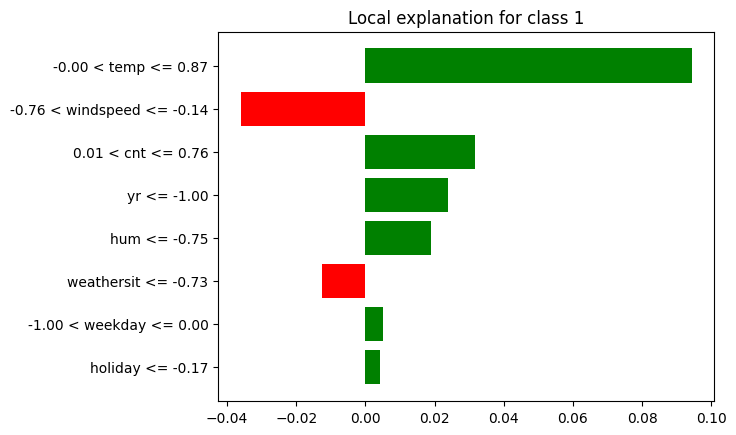

In [21]:
# LIME Explanation
explainer = LimeTabularExplainer(X_train, feature_names=features, class_names=[str(i) for i in range(num_classes)], discretize_continuous=True)

# Explain a single prediction
idx = 0  # Index of the sample to explain
exp = explainer.explain_instance(X_test[idx], lambda x: predict(x, W, b)[1], num_features=len(features))

# LIME Visualization
# exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()
plt.show()

# 📊 Explanation of the LIME Plot


This section explains how LIME interprets the Logistic Regression model prediction for a specific instance.

1. **Prediction Probabilities:**
   - The model predicts the likelihood of each class (0, 1, 2, 3).
   - Example: Class 2 has the highest probability (48%), making it the predicted class.

2. **Feature Contributions:**
   - **Green Bars (Positive Influence):** Features pushing the prediction towards the predicted class.
     - Example: `temp` significantly increases the prediction probability for Class 2.
   - **Red Bars (Negative Influence):** Features pulling the prediction away from the predicted class.
     - Example: `windspeed` and `weathersit` decrease the likelihood of predicting Class 2.

3. **Feature Values:**
   - Shows actual feature values for the explained instance.
   - Example: High `temp` (0.72) and moderate `cnt` (0.35) support the prediction, while low `windspeed` (-0.29) opposes it.

4. **Overall Interpretation:**
   - The model predicts **Class 2** mainly due to high **temperature** and moderate **count**.
   - Negative influences like **windspeed** and **weathersit** were not strong enough to change the prediction.


In [22]:
# Standard Deviation for Metrics
def compute_std_metric(y_true, y_pred):
    correct_predictions = (y_true == y_pred).astype(int)
    return np.std(correct_predictions)


In [23]:
# Compute Accuracy and Standard Deviation
train_accuracy = np.mean(y_pred_train == y_train)
test_accuracy = np.mean(y_pred_test == y_test)
train_std = compute_std_metric(y_train.values, y_pred_train)
test_std = compute_std_metric(y_test.values, y_pred_test)

print(f"Training Accuracy: {train_accuracy:.4f} ± {train_std:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f} ± {test_std:.4f}")

Training Accuracy: 0.6524 ± 0.4762
Testing Accuracy: 0.6463 ± 0.4781


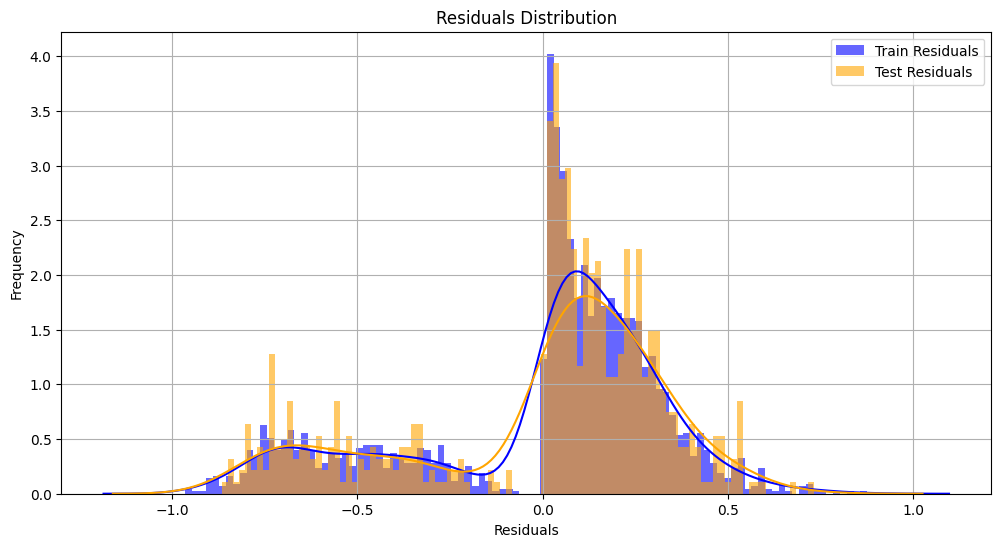

In [24]:
# Residuals Calculation
def compute_residuals(y_true, y_prob):
    y_true_one_hot = one_hot_encode(y_true, y_prob.shape[1])
    residuals = y_prob - y_true_one_hot
    return residuals.flatten()

train_residuals = compute_residuals(y_train.values, y_prob_train)
test_residuals = compute_residuals(y_test.values, y_prob_test)

# Plot Residuals Distribution
plt.figure(figsize=(12, 6))
plt.hist(train_residuals, bins=100, alpha=0.6, color='blue', density=True, label='Train Residuals')
plt.hist(test_residuals, bins=100, alpha=0.6, color='orange', density=True, label='Test Residuals')
sns.kdeplot(train_residuals, color='blue')
sns.kdeplot(test_residuals, color='orange')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.grid(True)
plt.show()

### Residuals Distribution Plot Explanation

**Residuals** are the differences between the predicted probabilities and the actual one-hot encoded labels. They help in identifying how well the model predicts each class.

#### 🔎 Plot Components:
- **Blue Bars:** Residuals for the **training set**
- **Orange Bars:** Residuals for the **testing set**
- **Density Curves:** Show how the residuals are distributed.

#### 📈 Interpretation:
- **Sharp Peak at 0:** Most predictions are correct.
- **Spread:** Wider spread indicates higher misclassification.
- **Symmetry:** A balanced distribution suggests no model bias.
- **Outliers:** Points far from zero indicate misclassifications.

#### ⚠️ Insights:
- If the **testing** residuals are more spread than **training**, the model might be overfitting.
- A shift away from zero might indicate bias in predictions.


In [25]:
print("Training Metrics:")
print("Accuracy:", train_accuracy)
print("Precision (Macro):", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1-Score (Macro):", train_f1)
print("AUC (ROC):", train_auc)
print("AUPRC:", train_auprc)

print("\nTesting Metrics:")
print("Accuracy:", test_accuracy)
print("Precision (Macro):", test_precision)
print("Recall (Sensitivity):", test_recall)
print("F1-Score (Macro):", test_f1)
print("AUC (ROC):", test_auc)
print("AUPRC:", test_auprc)

Training Metrics:
Accuracy: 0.6523972602739726
Precision (Macro): 0.6368152450635138
Recall (Sensitivity): 0.6505300770138069
F1-Score (Macro): 0.6435996050325526
AUC (ROC): 0.8759121293566714
AUPRC: 0.7071453505228316

Testing Metrics:
Accuracy: 0.6462585034013606
Precision (Macro): 0.6248037676609105
Recall (Sensitivity): 0.6446874506085032
F1-Score (Macro): 0.6345898928753619
AUC (ROC): 0.8705875413625292
AUPRC: 0.670851019244788
